In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4500)])
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
from glob import glob
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
Mask = glob('train/Mask/*.jpg')
No_Mask = glob('train/No_Mask/*.jpg')

Mask_train, Mask_test = train_test_split(Mask, test_size=0.30)
No_Mask_train, No_Mask_test = train_test_split(No_Mask, test_size=0.30)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

!mkdir test

!mkdir test/Mask
files = ' '.join(Mask_test)
!mv -t test/Mask $files

!mkdir test/No_Mask
files = ' '.join(No_Mask_test)
!mv -t test/No_Mask $files

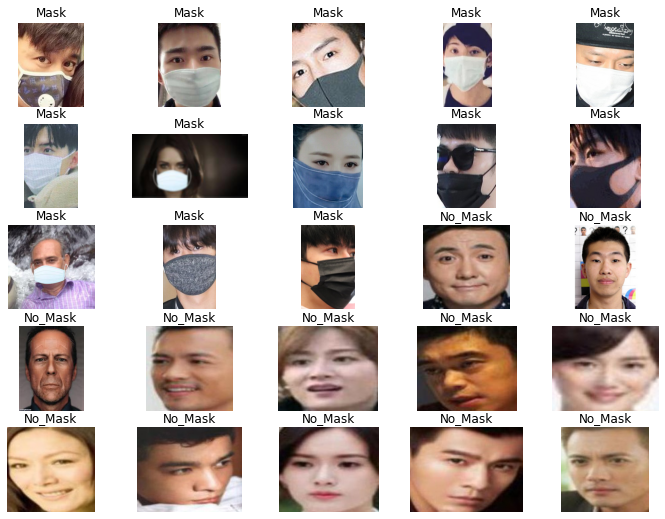

In [4]:
Mask = np.random.choice(Mask_train, 13)
No_Mask = np.random.choice(No_Mask_train, 12)
data = np.concatenate((Mask, No_Mask))
labels = 13 * ['Mask'] + 12 *['No_Mask']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

In [5]:
CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

head = base_model.output
head = GlobalAveragePooling2D(name='avg_pool')(head)
head = Dropout(0.4)(head)
head = Dense(CLASSES, activation='softmax')(head)
model = Model(inputs=base_model.input, outputs=head)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 3929 images belonging to 2 classes.
Found 1685 images belonging to 2 classes.


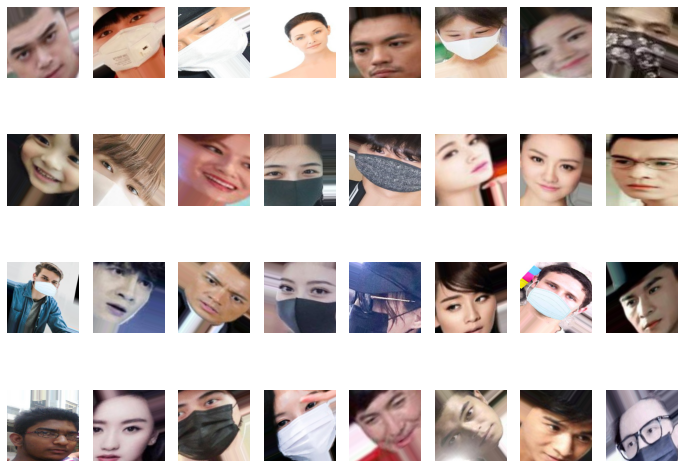

In [7]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [8]:
EPOCHS = 6
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'MaskD.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/6
320/320 [==============================] - 167s 521ms/step - loss: 0.3110 - accuracy: 0.8684 - val_loss: 0.2095 - val_accuracy: 0.9185
Epoch 2/6
320/320 [==============================] - 189s 592ms/step - loss: 0.1994 - accuracy: 0.9211 - val_loss: 0.2586 - val_accuracy: 0.9043
Epoch 3/6
320/320 [==============================] - 189s 591ms/step - loss: 0.1799 - accuracy: 0.9303 - val_loss: 0.3548 - val_accuracy: 0.8841
Epoch 4/6
320/320 [==============================] - 191s 596ms/step - loss: 0.1645 - accuracy: 0.9379 - val_loss: 0.1914 - val_accuracy: 0.9347
Epoch 5/6
320/320 [==============================] - 189s 589ms/step - loss: 0.1665 - accuracy: 0.9370 - val_loss: 0.2528 - val_accuracy: 0.9166
Epoch 6/6
320/320 [==============================] - 188s 586ms/step - loss: 0.1595 - accuracy: 0.9369 - val_loss: 0.2210 - val_accuracy: 0.9259
INFO:tensorflow:Assets written to: MaskD.model/assets
